# Sentence BERT clustering demo

In [24]:
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer

## Fetch news dataset

In [25]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
idxs = [ i for i in range(len(newsgroups_train.data)) if len(newsgroups_train.data[i]) > 20 ]
newsgroups_train.data = [ newsgroups_train.data[i] for i in idxs ]
newsgroups_train.target = [ newsgroups_train.target[i] for i in idxs ]

In [26]:
print("Train data size: ", len(newsgroups_train.data))

print("Average train data length: ", np.mean([len(x.split()) for x in newsgroups_train.data]))

print("Train data labels: ", newsgroups_train.target_names)
print("Number of train data labels: ", len(newsgroups_train.target_names))

print(f"Example:\n[{newsgroups_train.target_names[newsgroups_train.target[0]]}] ", newsgroups_train.data[0])

Train data size:  10955
Average train data length:  191.90652670013694
Train data labels:  ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Number of train data labels:  20
Example:
[rec.autos]  I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car,

In [27]:
json_data = {}
json_data['dataset'] = {
    'target_names': newsgroups_train.target_names,
    'samples': [ {
        'data': newsgroups_train.data[i],
        'target': int(newsgroups_train.target[i])
    } for i in range(len(newsgroups_train.data)) ]
}
json_data['zoom_levels'] = [1]

In [28]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
train_embeddings = model.encode(newsgroups_train.data, show_progress_bar=True)
train_embeddings.shape

Batches: 100%|██████████| 343/343 [00:19<00:00, 17.86it/s]


(10955, 384)

In [29]:
from sklearn.cluster import KMeans
num_clusters = 20 # Could be optimized later using validation indices
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto').fit(train_embeddings)

In [30]:
json_data['clusters'] = kmeans.labels_.tolist()

## Create the graph using tSNE
We use tSNE simply to reduce the dimensionality of the embeddings to 2D for visualization. This is unnecessary; should remove.

In [31]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000, n_iter_without_progress=200, perplexity=35)
tsne_embeddings = tsne.fit_transform(train_embeddings)

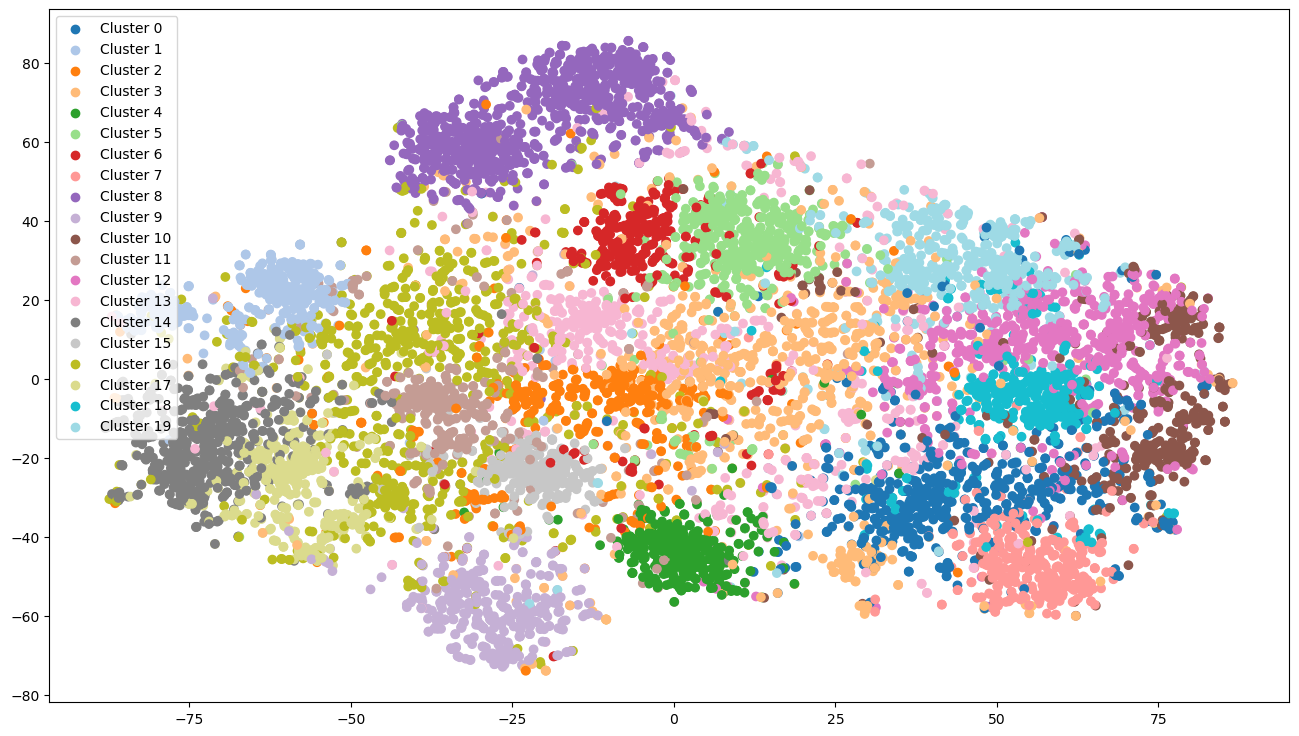

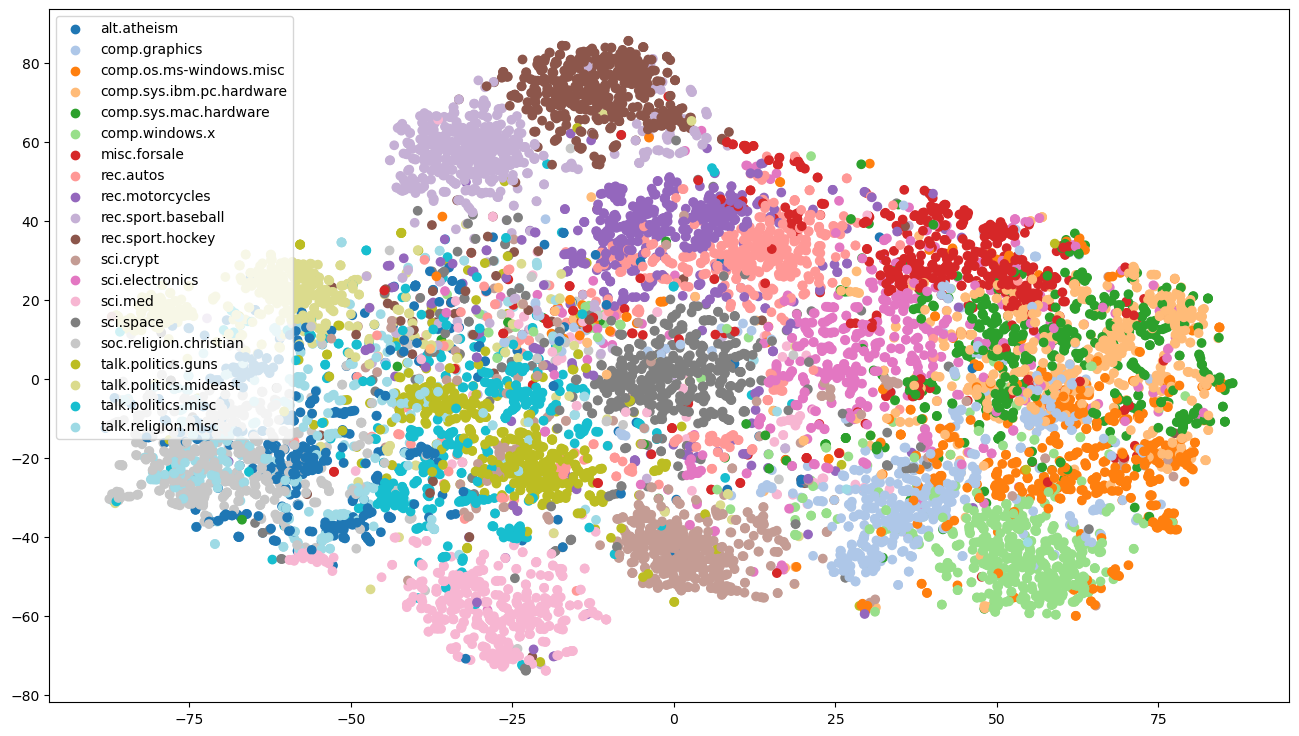

In [32]:
plt.figure(figsize=(16, 9))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=kmeans.labels_, cmap='tab20')
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=f"Cluster {i}") for i in range(20)])
plt.show()

plt.figure(figsize=(16, 9))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=newsgroups_train.target, cmap='tab20')
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=newsgroups_train.target_names[i]) for i in range(20)])
plt.show()

In [33]:
json_data['tsne_embeddings'] = tsne_embeddings.tolist()

## Create the graph using PyVis
Testing the library Pyvis to create an interactive graph in 2D. Good luck loading this lol.
What even is this wtf

In [41]:
""" from pyvis.network import Network
net_pred = Network(notebook=True, cdn_resources="in_line")
net_trgt = Network(notebook=True)

for i in range(len(train_embeddings)):
    net_pred.add_node(i, label=newsgroups_train.data[i][:50], color=plt.cm.tab20(kmeans.labels_[i]/20))
    net_trgt.add_node(i, label=newsgroups_train.data[i][:50], color=plt.cm.tab20(newsgroups_train.target[i]/20))

net_pred.show("pred.html")
net_trgt.show("trgt.html") """

' from pyvis.network import Network\nnet_pred = Network(notebook=True, cdn_resources="in_line")\nnet_trgt = Network(notebook=True)\n\nfor i in range(len(train_embeddings)):\n    net_pred.add_node(i, label=newsgroups_train.data[i][:50], color=plt.cm.tab20(kmeans.labels_[i]/20))\n    net_trgt.add_node(i, label=newsgroups_train.data[i][:50], color=plt.cm.tab20(newsgroups_train.target[i]/20))\n\nnet_pred.show("pred.html")\nnet_trgt.show("trgt.html") '

## Cluster labelling
We use LDA.

In [35]:
# Generate topics using LDA for each cluster
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

labels = {i : '' for i in range(num_clusters)}

cluster_keywords = []

for i in range(num_clusters):
    cluster_data = [newsgroups_train.data[j] for j in range(len(newsgroups_train.data)) if kmeans.labels_[j] == i]
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(cluster_data)
    lda = LatentDirichletAllocation(n_components=5, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(X)
    labels[i] = ', '.join([vectorizer.get_feature_names_out()[i] for i in [
        idx for idx in lda.components_[0].argsort() if not vectorizer.get_feature_names_out()[idx].isdigit()
    ][:-1 - 1:-1]])
    print(f"Cluster {i}")
    print("Top 10 words per topic:")
    kwds = []
    for topic_idx, topic in enumerate(lda.components_):
        feature_names = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1] if vectorizer.get_feature_names_out()[i] not in kwds and not vectorizer.get_feature_names_out()[i].isdigit()]
        kwds.extend(feature_names)
        print(f"Topic {topic_idx}: {', '.join(feature_names)}")
    cluster_keywords.append(kwds)
    print()

Cluster 0
Top 10 words per topic:
Topic 0: edu, ftp, version, image, data, available, contact, comments, machines, type
Topic 1: windows, entry, use, printer, entries, ms, program, paradox, nt, using
Topic 2: files, file, jpeg, know, like, thanks, does
Topic 3: s6, lk, sp, w1, mv, m6, r6, d9
Topic 4: lib, libx11, book, phigs, groups, icons, examples, error, mouse

Cluster 1
Top 10 words per topic:
Topic 0: said, people, know, didn, don, armenians, armenian, went, just, say
Topic 1: planes, armenia, kk, farid, negev, turkey, weapons, announced, yalcin
Topic 2: iran, killed, palestinian, soldiers, israeli, war, iraqi
Topic 3: turkish, turks, greek, government, genocide, jews
Topic 4: israel, mr, arab, think

Cluster 2
Top 10 words per topic:
Topic 0: launch, space, commercial, lunar, satellite, earth, market, dc, advertising, rocket
Topic 1: people, government, like, don, just, think, money, time, make
Topic 2: water, president, administration, russia, russian, senior, official, american

In [36]:
json_data['cluster_keywords'] = {i : cluster_keywords[i] for i in range(len(cluster_keywords))}

## Obtaining a 1-word summary of the keywords
It does not work well for now, we could perhaps improve it by training a model on (doc, topic) pairs comming from the intial dataset.

In [37]:
from transformers import AutoTokenizer, GPT2LMHeadModel

tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

query = f"A single word to define the topic given by the keywords [{', '.join(cluster_keywords[2])}] is: "
inputs = tokenizer(query, return_tensors='pt').input_ids
outputs = model.generate(inputs, max_new_tokens=10, do_sample=False)
label = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(label)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


A single word to define the topic given by the keywords [launch, space, commercial, lunar, satellite, earth, market, dc, advertising, rocket, people, government, like, don, just, think, money, time, make, water, president, administration, russia, russian, senior, official, american, package, capability, ssf, power, flights, option, module, com, station, nasa, redesign, astronaut, committee, program, options, technology] is:  "The term 'launch' is used to


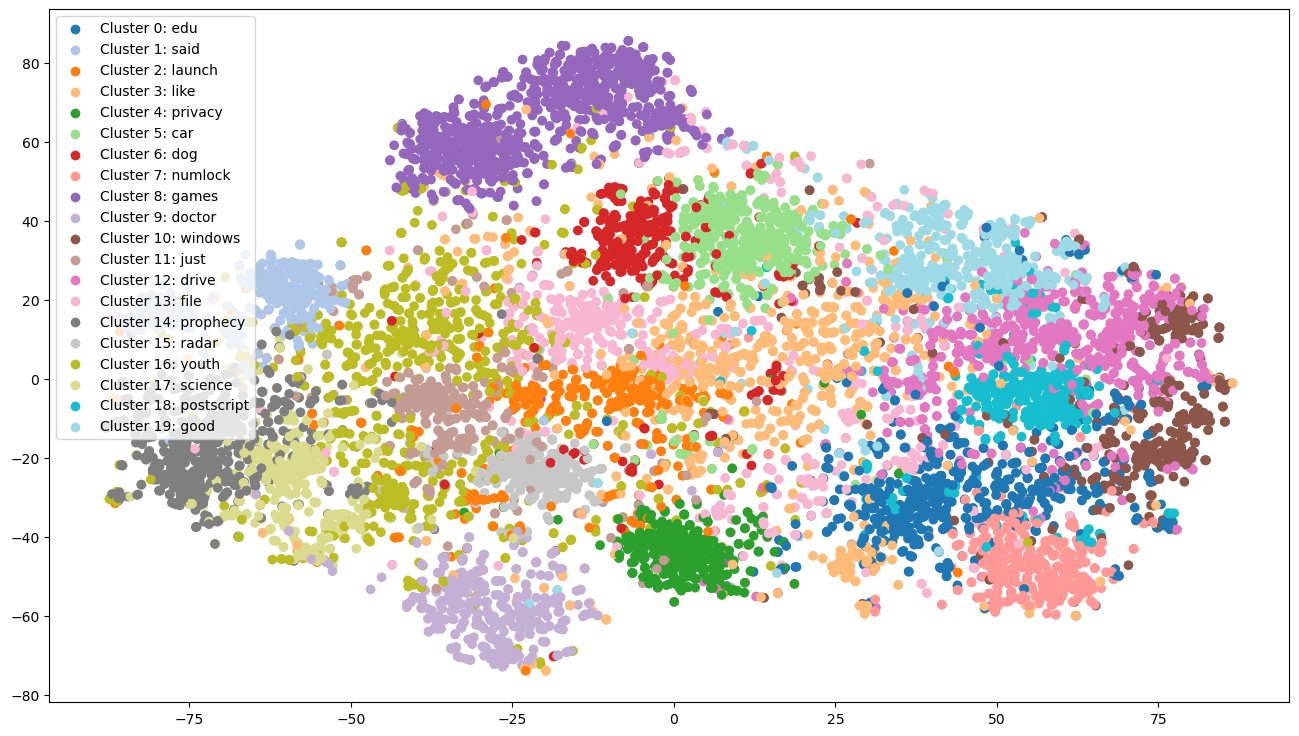

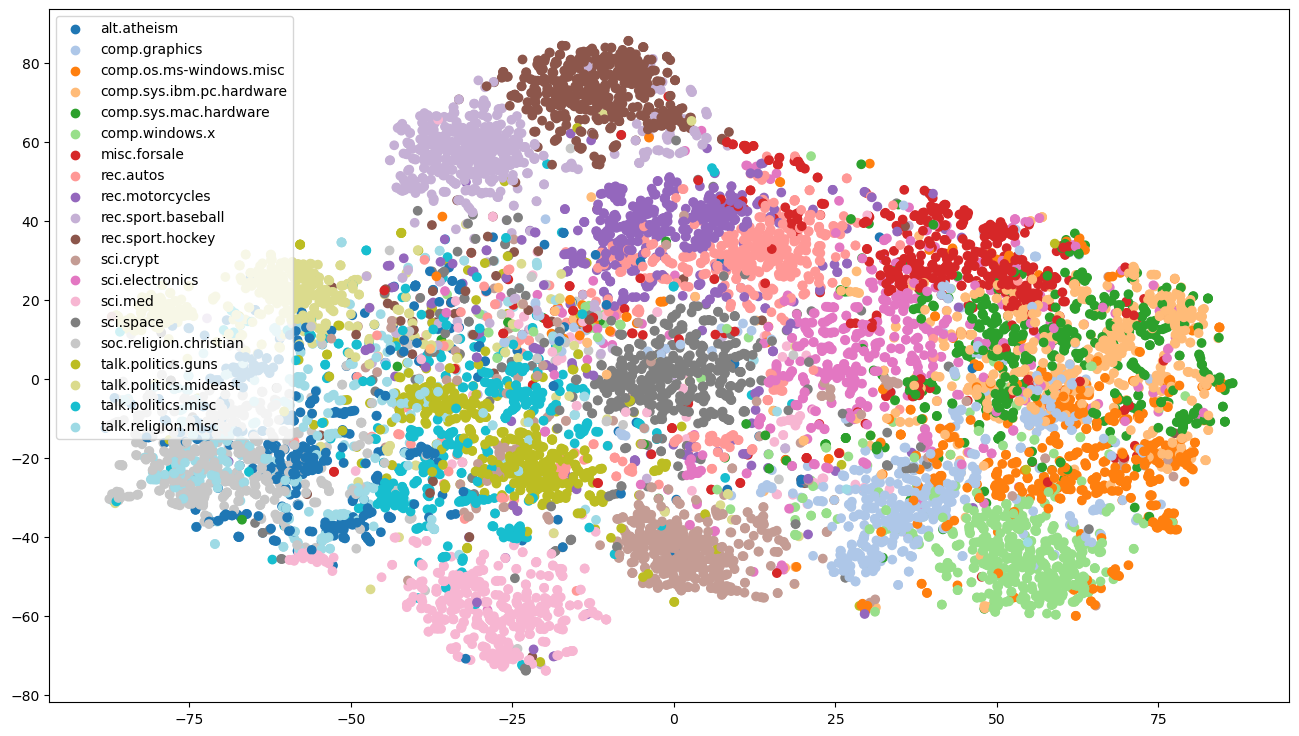

In [38]:
plt.figure(figsize=(16, 9))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=kmeans.labels_, cmap='tab20')
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=f"Cluster {i}: {labels[i]}") for i in range(20)])
plt.show()

plt.figure(figsize=(16, 9))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=newsgroups_train.target, cmap='tab20')
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=newsgroups_train.target_names[i]) for i in range(20)])
plt.show()

## Export JSON data
We export the data to a JSON file for use in the web app.

In [40]:
DATA_FOLDER = 'app/data'
with open(f'{DATA_FOLDER}/data.json', 'w+') as f:
    json.dump(json_data, f)